# Chapter 3: Eniac Data Cleaning (Analysis)

In [1]:
import os
import re
import math
import pandas as pd
import numpy as np
import seaborn as sns

## Import

In [2]:
os.chdir(os.path.join('..', 'data'))
tables_csv = [ csv for csv in os.listdir() if csv.endswith('.csv') ]

In [3]:
tables = {}
for table_csv in tables_csv:
    varname = table_csv.removesuffix('.csv')
    print(f'Reading {table_csv} into {varname} and {varname}_orig')
    tables[varname] = pd.read_csv(table_csv)
    tables[f'{varname}_orig'] = tables[varname].copy()

locals().update(tables)

Reading brands.csv into brands and brands_orig
Reading orderlines.csv into orderlines and orderlines_orig
Reading orderlines_cl.csv into orderlines_cl and orderlines_cl_orig
Reading orders.csv into orders and orders_orig
Reading orders_cl.csv into orders_cl and orders_cl_orig
Reading products.csv into products and products_orig
Reading products_cl.csv into products_cl and products_cl_orig
Reading type_to_name.csv into type_to_name and type_to_name_orig
Reading type_to_name_empty.csv into type_to_name_empty and type_to_name_empty_orig


In [4]:
orderlines_cl.date = pd.to_datetime(orderlines_cl.date)
orders_cl.created_date = pd.to_datetime(orders_cl.created_date)

## Config

In [5]:
pd.set_option('display.max_rows', 250)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

## Tools

### Range of confidence (outlier detection)

In [6]:
DEFAULT_IQR_FACTOR = 1.5

def range_of_confidence(series: pd.Series, iqr_factor = DEFAULT_IQR_FACTOR) -> pd.Series:
  '''
  Get series.describe() and add 'left'/'right' as confidence limits
  '''
  result = series.describe()
  q3 = result['75%']
  q1 = result['25%']
  iqr = q3 - q1
  result['iqr'] = iqr
  result['left'] = q1 - iqr_factor * iqr
  result['right'] = q3 + iqr_factor * iqr
  return result

def isin_range_of_confidence(series: pd.Series, iqr_factor = DEFAULT_IQR_FACTOR):
  roc = range_of_confidence(series, iqr_factor)
  return series.between(roc['left'], roc['right'])


### Value counts and proportion

In [7]:
def value_counts_and_proportion(df):
    return (
        df.value_counts()
        .reset_index()
        .assign(proportion=lambda x: x['count'] / x['count'].sum())
    )


## Time span

In [8]:
(
    orders_cl
    .agg({'created_date': ['min', 'max']})
)

,created_date
min,2017-01-01 01:51:47
max,2018-03-14 12:03:52


## Sales by product type

In [9]:
sales_by_type = (
    orderlines_cl
    .assign(total_price=lambda x: x.unit_price * x.product_quantity)
    .join(products.set_index('sku').type, on='sku')
    .join(type_to_name.set_index('type').name.rename('category').fillna('other'), on='type')
    .groupby('category')
    .agg(
        total_sales=('total_price', 'sum'),
        total_count=('product_quantity', 'sum'),
    )
    .assign(total_sales_proportion=lambda x: x.total_sales / x.total_sales.sum())
    .sort_values('total_sales', ascending=False)
    .assign(total_sales_order=lambda x: x.reset_index().index)
)
sales_by_type.style.format({'total_sales_proportion': '{:.2%}'})

,total_sales,total_count,total_sales_proportion,total_sales_order
category,,,,
imac_5k,17517118.380000,6017,43.83%,0
macbook_i5,5004105.620000,2178,12.52%,1
imac,3867981.710000,2240,9.68%,2
macbook_i7,2282451.000000,951,5.71%,3
nas,892499.880000,1685,2.23%,4
ext_hard_drive,886489.220000,4669,2.22%,5
monitor,777327.230000,1903,1.95%,6
macbook_13,756273.630000,617,1.89%,7
imac_2,505137.960000,326,1.26%,8


In [10]:
sales_by_product = (
    orderlines_cl
    .assign(total_price=lambda x: x.unit_price * x.product_quantity)
    .groupby('sku')
    .agg(
        total_sales=('total_price', 'sum'),
        total_count=('product_quantity', 'sum'),
    )
    .assign(total_sales_proportion=lambda x: x.total_sales / x.total_sales.sum())
    .sort_values('total_sales', ascending=False)
    .assign(total_sales_order=lambda x: x.reset_index().index)
)
sales_by_product

,total_sales,total_count,total_sales_proportion,total_sales_order
sku,,,,
APP2075,215485.71,71,0.01,0
APP2074,156383.56,61,0.01,1
APP2490,155727.70,137,0.01,2
LGE0044,140272.29,248,0.01,3
APP2489,137530.55,121,0.01,4
...,...,...,...,...
CAD0008,1.39,1,0.00,6043
CAD0010,0.58,2,0.00,6044
SEV0018,0.01,1,0.00,6045


## Per-product discount analysis

#### Statistics about per-product prices

In [11]:
unit_price_stats = (
    orderlines_cl
    .groupby('sku')
    .unit_price
    .apply(range_of_confidence)
    .unstack()
    .assign(
        range_percent=lambda x: 100*(x['max']-x['min'])/(x['max']),
        iqr_percent=lambda x: 100*(2 * x['iqr'] / (x['25%'] + x['75%']))
    )
    .join(orderlines_cl.set_index('sku')[['unit_price']])
    .assign(
        left_outlier=lambda x: x['unit_price'] < x['left'],
        right_outlier=lambda x: x['unit_price'] > x['right'],
    )
)

In [12]:
unit_price_stats_agg = { col: (col, 'first') for col in unit_price_stats.columns }
del unit_price_stats_agg['left_outlier']
unit_price_stats_agg['left_outliers'] = ('left_outlier','sum')
del unit_price_stats_agg['right_outlier']
unit_price_stats_agg['right_outliers'] = ('right_outlier','sum')
# del unit_price_stats_agg['left_badness']
# unit_price_stats_agg['max_left_badness'] = ('left_badness','max')
# del unit_price_stats_agg['right_badness']
# unit_price_stats_agg['max_right_badness'] = ('right_badness','max')
del unit_price_stats_agg['unit_price']
unit_price_stats_agg

unit_price_stats= (
    unit_price_stats
    .groupby('sku')
    .agg(**unit_price_stats_agg)
    .assign(
        total_outliers=lambda x: x.left_outliers + x.right_outliers,
        total_outliers_percent=lambda x: x.total_outliers / x['count'] * 100)
)
#(
#    unit_price_stats
#    [lambda x: x.total_outliers > 0]
#    .sort_values('total_outliers', ascending=False)
#)

In [13]:
discounts = (
    orderlines_cl
    .join(products_cl.set_index('sku')[['price','type']].rename(columns={
        'price': 'list_price',
    }), on='sku')
    .join(unit_price_stats[['min','max']].rename(columns={'min': 'min_sale', 'max': 'max_sale'}), on='sku')
    .assign(
        discount_max_sale=lambda x: (1-x['unit_price']/x['max_sale']).fillna(0),
        discount_list=lambda x: (1-x['unit_price']/x['list_price']).fillna(0),
        total_price=lambda x: x['unit_price'] * x['product_quantity']
    )
)

In [14]:
(discounts.discount_max_sale.isna()).sum()

0

In [15]:
first_date = (
    orderlines_cl
    .date
    .sort_values()
    .head(1)
    [0]
    .to_period('W')
    .to_timestamp()
)
first_date

Timestamp('2016-12-26 00:00:00')

In [16]:
weekly_discounts = (
    discounts
    .assign(week=lambda x: x.date.dt.to_period('W'))
    .pipe(lambda x:
         x.groupby(['sku', 'week'])
    )
    .agg(
        type = ('type', 'first'),
        avg_discount_max_sale = ('discount_max_sale', 'mean'),
        avg_discount_list = ('discount_list', 'mean'),
        weekly_sales_count = ('product_quantity', 'sum'),
        weekly_revenue = ('total_price', 'sum')
    )
    .join(type_to_name.set_index('type').name.rename('category').fillna('other'), on='type')
    .join(sales_by_type.total_sales, on='category')
    .assign(
        week_nr=lambda x: (x.index.get_level_values(1).to_timestamp() - first_date).days // 7,
        #week_nr=lambda x: (x.index.get_level_values(1).to_timestamp()),
        rel_weekly_sales_count=lambda x:
            x.weekly_sales_count / x.groupby('sku').weekly_sales_count.transform('max')
    )
    .sort_values(['total_sales', 'sku', 'week'], ascending=[False, True, True])
    .reset_index()
)
weekly_discounts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35619 entries, 0 to 35618
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype        
---  ------                  --------------  -----        
 0   sku                     35619 non-null  object       
 1   week                    35619 non-null  period[W-SUN]
 2   type                    35409 non-null  object       
 3   avg_discount_max_sale   35619 non-null  float64      
 4   avg_discount_list       35619 non-null  float64      
 5   weekly_sales_count      35619 non-null  int64        
 6   weekly_revenue          35619 non-null  float64      
 7   category                35376 non-null  object       
 8   total_sales             35376 non-null  float64      
 9   week_nr                 35619 non-null  int64        
 10  rel_weekly_sales_count  35619 non-null  float64      
dtypes: float64(5), int64(2), object(3), period[W-SUN](1)
memory usage: 3.0+ MB


In [17]:
weekly_discounts.sort_values('weekly_sales_count', ascending=False).head(10)

,sku,week,type,avg_discount_max_sale,avg_discount_list,weekly_sales_count,weekly_revenue,category,total_sales,week_nr,rel_weekly_sales_count
21700,APP1190,2017-11-20/2017-11-26,1231,0.27,0.27,233,11874.15,applecare,127418.09,47,1.00
13398,APP1922,2017-11-20/2017-11-26,5384,0.14,0.14,198,30465.26,headphone,269496.76,47,1.00
13903,PAC2477,2017-12-18/2017-12-24,5384,0.41,0.67,164,3264.48,headphone,269496.76,51,1.00
11888,MAC0144,2018-02-26/2018-03-04,11905404,0.00,0.37,149,3723.51,gadgets,318926.88,61,1.00
28894,BEL0198,2017-01-09/2017-01-15,13615399,0.45,0.54,130,2075.93,iphone_charger,35199.03,2,1.00
31492,ZAG0032,2018-01-08/2018-01-14,12575403,0.66,0.69,114,3502.46,ipad_keyboard,24972.97,54,1.00
32033,BEL0303,2017-07-03/2017-07-09,1392,0.54,0.60,107,2455.94,macbook_backpack,21176.15,27,1.00
31477,ZAG0030,2017-10-16/2017-10-22,12575403,0.60,0.75,107,2135.46,ipad_keyboard,24972.97,42,1.00
30346,APP0698,2017-11-20/2017-11-26,1230,0.39,0.63,102,930.98,lightning_cable,25882.32,47,1.00
10877,WDT0183,2017-11-20/2017-11-26,12655397,0.20,0.22,91,12000.49,pc_hard_drive,410349.41,47,1.00


In [18]:
category_correlations = (
    weekly_discounts
    #[lambda x: x.category.isin(sales_by_type.head(5).index)]
    .reset_index()
    .groupby('category')
    [['avg_discount_max_sale', 'rel_weekly_sales_count']]
    .corr('pearson')
    .loc[(slice(None), 'avg_discount_max_sale'), 'rel_weekly_sales_count']
    .reset_index(1, drop=True)
    .rename('corr')
    .to_frame()
    .join(
        weekly_discounts
        .groupby('category')
        .apply(lambda x:
               np.polyfit(x.avg_discount_max_sale, x.rel_weekly_sales_count, 1)[0])
        .rename('slope'),
        on='category'
    )
    .join(sales_by_type, on='category')
)

In [19]:
category_correlations.sort_values('total_sales_order')

,corr,slope,total_sales,total_count,total_sales_proportion,total_sales_order
category,,,,,,
imac_5k,-0.10,-1.04,17517118.38,6017,0.44,0
macbook_i5,-0.12,-1.42,5004105.62,2178,0.13,1
imac,-0.11,-0.95,3867981.71,2240,0.10,2
macbook_i7,-0.03,-0.40,2282451.00,951,0.06,3
nas,-0.15,-1.12,892499.88,1685,0.02,4
ext_hard_drive,-0.26,-0.86,886489.22,4669,0.02,5
monitor,0.05,0.26,777327.23,1903,0.02,6
macbook_13,-0.14,-1.68,756273.63,617,0.02,7
imac_2,-0.10,-2.10,505137.96,326,0.01,8


In [20]:
category_correlations.sort_values('corr', ascending=False)

,corr,slope,total_sales,total_count,total_sales_proportion,total_sales_order
category,,,,,,
macbook_battery,0.20,0.78,83491.04,884,0.00,35
wacom_accessory,0.18,0.68,5044.38,145,0.00,83
ipad_mini_4,0.16,1.05,19599.24,40,0.00,62
bluetooth_keyboard,0.14,0.34,19279.82,171,0.00,63
mac_pro_ram,0.13,0.69,124487.94,29,0.00,31
ipad_air,0.12,1.03,25253.25,53,0.00,57
ssd_adapter_kit,0.11,0.57,36243.34,1060,0.00,50
macbook_pro_back,0.09,0.41,7606.58,204,0.00,78
ipad,0.08,0.88,136815.72,306,0.00,26


In [21]:
product_correlations = (
    weekly_discounts
    .reset_index()
    .groupby('sku')
    [['avg_discount_max_sale', 'rel_weekly_sales_count']]
    .corr('pearson')
    .loc[(slice(None), 'avg_discount_max_sale'), 'rel_weekly_sales_count']
    .reset_index(1, drop=True)
    .rename('corr')
    .to_frame()
    .join(
        weekly_discounts
        .groupby('sku')
        .filter(lambda x: x.avg_discount_max_sale.nunique() >= 2)
        .groupby('sku')
        .apply(lambda x:
               np.polyfit(x.avg_discount_max_sale, x.rel_weekly_sales_count, 1)[0])
        .rename('slope'),
        on='sku'
    )
    .join(sales_by_product, on='sku')
)

In [22]:
def correlations_style(df):
  return df.style.format(precision=2).format('{:.2%}', ['total_sales_proportion'])

In [23]:
product_correlations.sort_values('total_sales_order').head(50).pipe(correlations_style)

,corr,slope,total_sales,total_count,total_sales_proportion,total_sales_order
sku,,,,,,
APP2075,0.39,3.69,215485.71,71,1.37%,0
APP2074,0.37,3.15,156383.56,61,1.00%,1
APP2490,0.10,1.23,155727.70,137,0.99%,2
LGE0044,0.23,1.83,140272.29,248,0.89%,3
APP2489,-0.39,-6.17,137530.55,121,0.88%,4
APP2072,0.41,4.64,130197.91,132,0.83%,5
PAC2136,0.51,8.09,128745.54,61,0.82%,6
APP2073,0.59,5.16,121385.77,99,0.77%,7
APP2089,0.83,11.92,113149.65,58,0.72%,8


In [24]:
product_correlations.sort_values(['corr', 'slope'], ascending=False).head(50).pipe(correlations_style)

,corr,slope,total_sales,total_count,total_sales_proportion,total_sales_order
sku,,,,,,
KEN0200,1.00,3.37,509.93,7,0.00%,2677
BOO0092,1.00,3.33,284.94,6,0.00%,3344
FCM0012,1.00,3.00,95.94,6,0.00%,4529
WOE0011,1.00,4540789502368759.00,93.94,6,0.00%,4550
APP2547,1.00,156.75,468.45,5,0.00%,2761
LGE0028-A,1.00,132.99,795.97,3,0.01%,2187
PAC2099,1.00,88.11,11564.36,4,0.07%,294
APP2293,1.00,37.98,7361.59,3,0.05%,454
APP2242,1.00,35.55,5493.77,3,0.03%,578


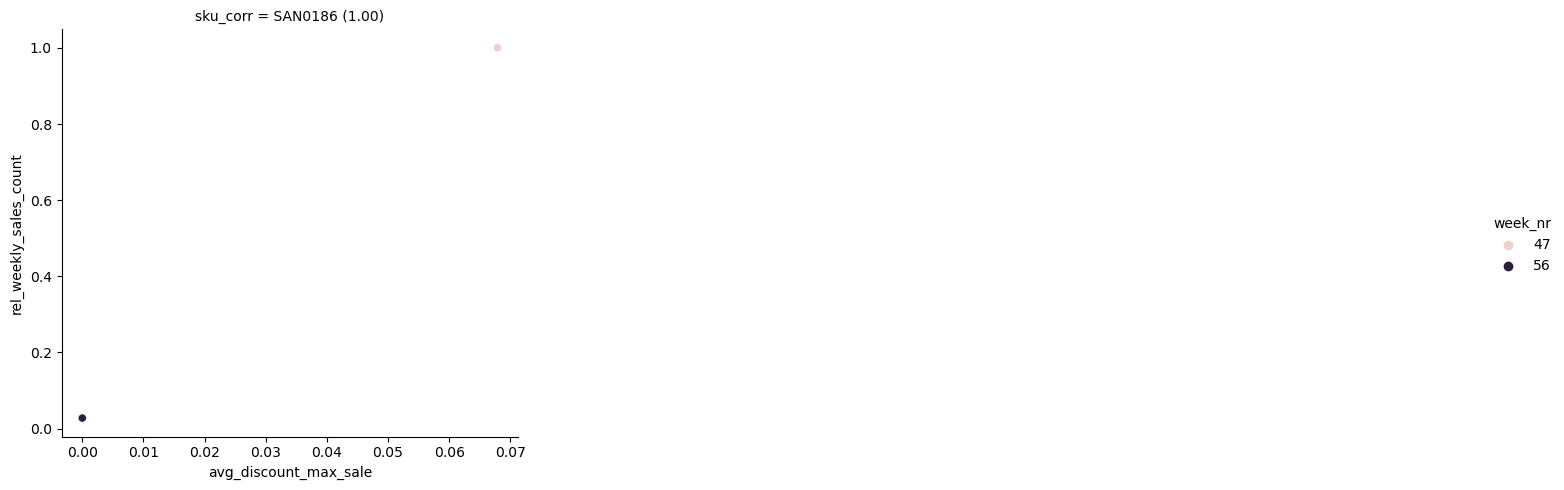

In [25]:
sns.relplot(
    data=(
        weekly_discounts
        .query('sku == "SAN0186"')
        .join(product_correlations['corr'], on='sku')
        .assign(sku_corr=lambda x: x.apply(lambda r: f'{r.sku} ({r["corr"]:.2f})', axis=1))
        .sort_values(['corr'], ascending=False)
    ),
    x='avg_discount_max_sale',
    y='rel_weekly_sales_count',
    hue='week_nr',
    col='sku_corr',
    col_wrap=3
);

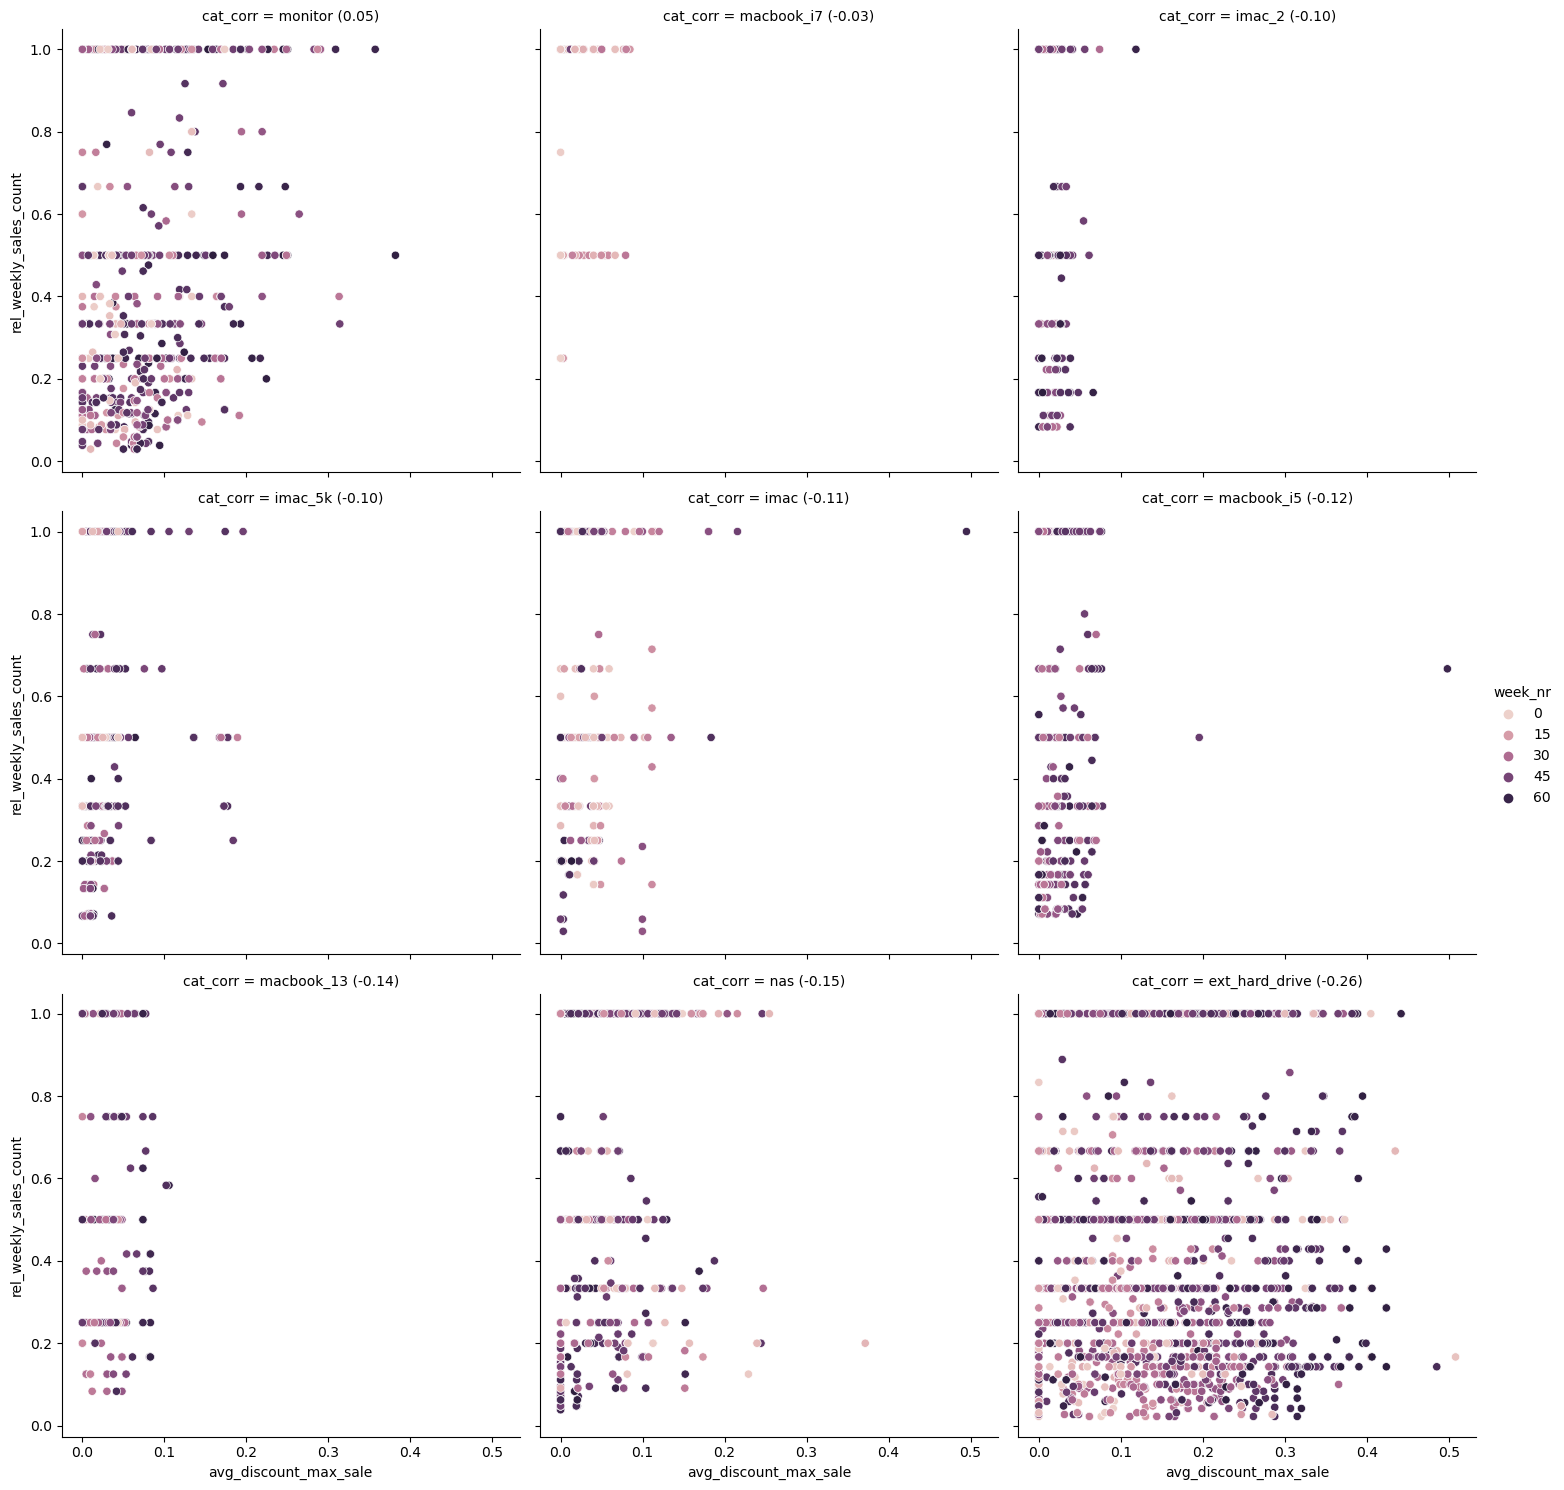

In [26]:
sns.relplot(
    data=(
        weekly_discounts
        [lambda x: x.category.isin(sales_by_type.head(9).index)]
        .join(category_correlations[['corr']], on='category')
        #.join(correlations, on='sku')
        .assign(cat_corr=lambda x: x.apply(lambda r: f'{r.category} ({r["corr"]:.2f})', axis=1))
        #.assign(cat_corr=lambda x: x.apply(lambda r: f'{r.sku} ({r["corr"]:.2f})', axis=1))
        .sort_values(['corr'], ascending=False)
    ),
    x='avg_discount_max_sale',
    y='rel_weekly_sales_count',
    hue='week_nr',
    col='cat_corr',
    col_wrap=3
);